In [69]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [70]:
# Load the dataset
data = pd.read_csv('data/gold.csv')

In [71]:
data.columns = [i.lower() for i in data.columns]
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'del_quantity', 'currency'], dtype='object')

In [72]:
data.head()

,date,open,high,low,close,del_quantity,currency
0,2000-01-04,289.5,289.5,280.0,283.7,21621,USD
1,2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2,2000-01-06,281.6,282.8,280.2,282.4,19055,USD
3,2000-01-07,282.5,284.5,282.0,282.9,11266,USD
4,2000-01-10,282.4,283.9,281.8,282.7,30603,USD


In [73]:
data.drop(columns=['del_quantity', 'currency'], inplace=True)

In [74]:
data.head()

,date,open,high,low,close
0,2000-01-04,289.5,289.5,280.0,283.7
1,2000-01-05,283.7,285.0,281.0,282.1
2,2000-01-06,281.6,282.8,280.2,282.4
3,2000-01-07,282.5,284.5,282.0,282.9
4,2000-01-10,282.4,283.9,281.8,282.7


In [75]:
data.isna().any()

date     False
open     False
high     False
low      False
close    False
dtype: bool

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5702 entries, 0 to 5701
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5702 non-null   object 
 1   open    5702 non-null   float64
 2   high    5702 non-null   float64
 3   low     5702 non-null   float64
 4   close   5702 non-null   float64
dtypes: float64(4), object(1)
memory usage: 222.9+ KB


In [77]:
data.shape

(5702, 5)

In [78]:
data.duplicated().sum()

0

In [79]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date',inplace=True)

In [80]:
data.head()

,open,high,low,close
date,,,,
2000-01-04,289.5,289.5,280.0,283.7
2000-01-05,283.7,285.0,281.0,282.1
2000-01-06,281.6,282.8,280.2,282.4
2000-01-07,282.5,284.5,282.0,282.9
2000-01-10,282.4,283.9,281.8,282.7


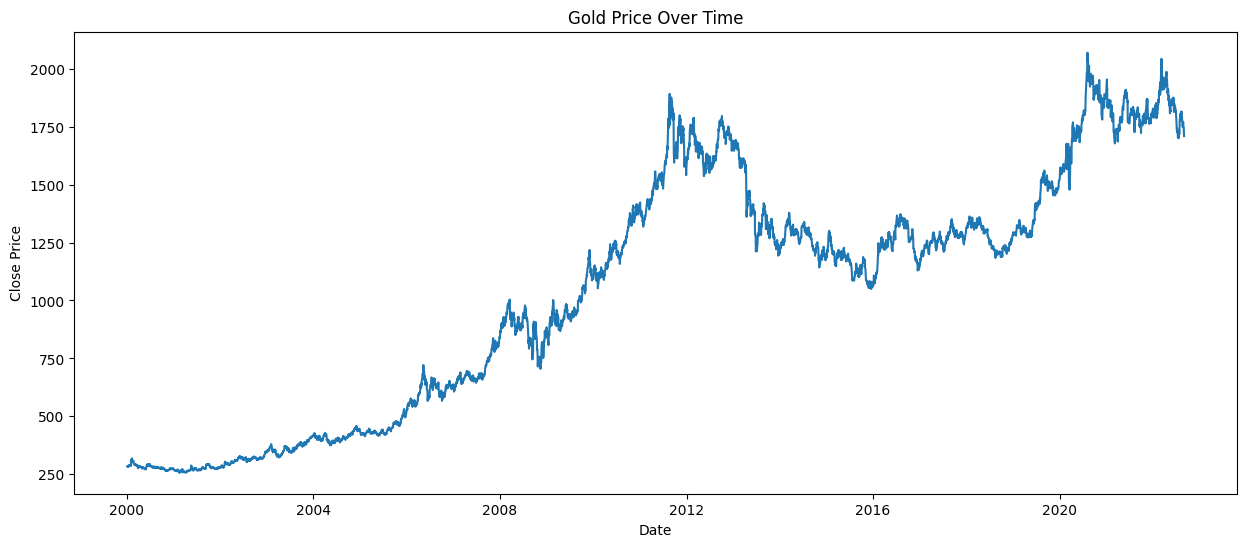

In [81]:
# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(data['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Gold Price Over Time')
plt.show()

In [82]:
data.index.min()

Timestamp('2000-01-04 00:00:00')

In [83]:
data.index.max()

Timestamp('2022-09-01 00:00:00')

In [84]:
# data = data.filter(['close'])

torch.Size([5502, 200, 4]) torch.Size([5502, 4])
cuda
Epoch [1/50], Train Loss: 0.0224, Val Loss: 0.0089
Epoch [2/50], Train Loss: 0.0037, Val Loss: 0.0029
Epoch [3/50], Train Loss: 0.0026, Val Loss: 0.0004
Epoch [4/50], Train Loss: 0.0023, Val Loss: 0.0005
Epoch [5/50], Train Loss: 0.0019, Val Loss: 0.0003
Epoch [6/50], Train Loss: 0.0017, Val Loss: 0.0005
Epoch [7/50], Train Loss: 0.0017, Val Loss: 0.0003
Epoch [8/50], Train Loss: 0.0015, Val Loss: 0.0003
Epoch [9/50], Train Loss: 0.0014, Val Loss: 0.0002
Epoch [10/50], Train Loss: 0.0013, Val Loss: 0.0003
Epoch [11/50], Train Loss: 0.0012, Val Loss: 0.0005
Epoch [12/50], Train Loss: 0.0012, Val Loss: 0.0015
Epoch [13/50], Train Loss: 0.0011, Val Loss: 0.0002
Epoch [14/50], Train Loss: 0.0011, Val Loss: 0.0002
Epoch [15/50], Train Loss: 0.0009, Val Loss: 0.0010
Epoch [16/50], Train Loss: 0.0010, Val Loss: 0.0005
Epoch [17/50], Train Loss: 0.0009, Val Loss: 0.0004
Epoch [18/50], Train Loss: 0.0008, Val Loss: 0.0003
Epoch [19/50], Trai

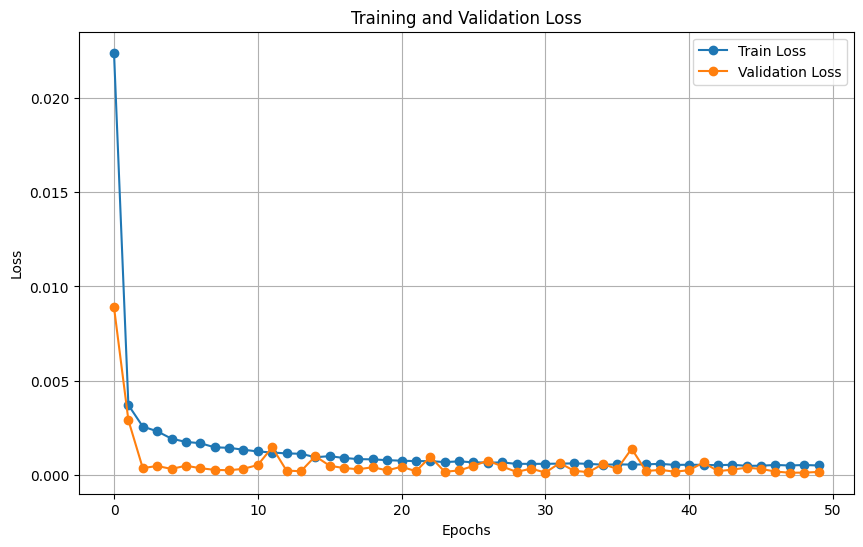

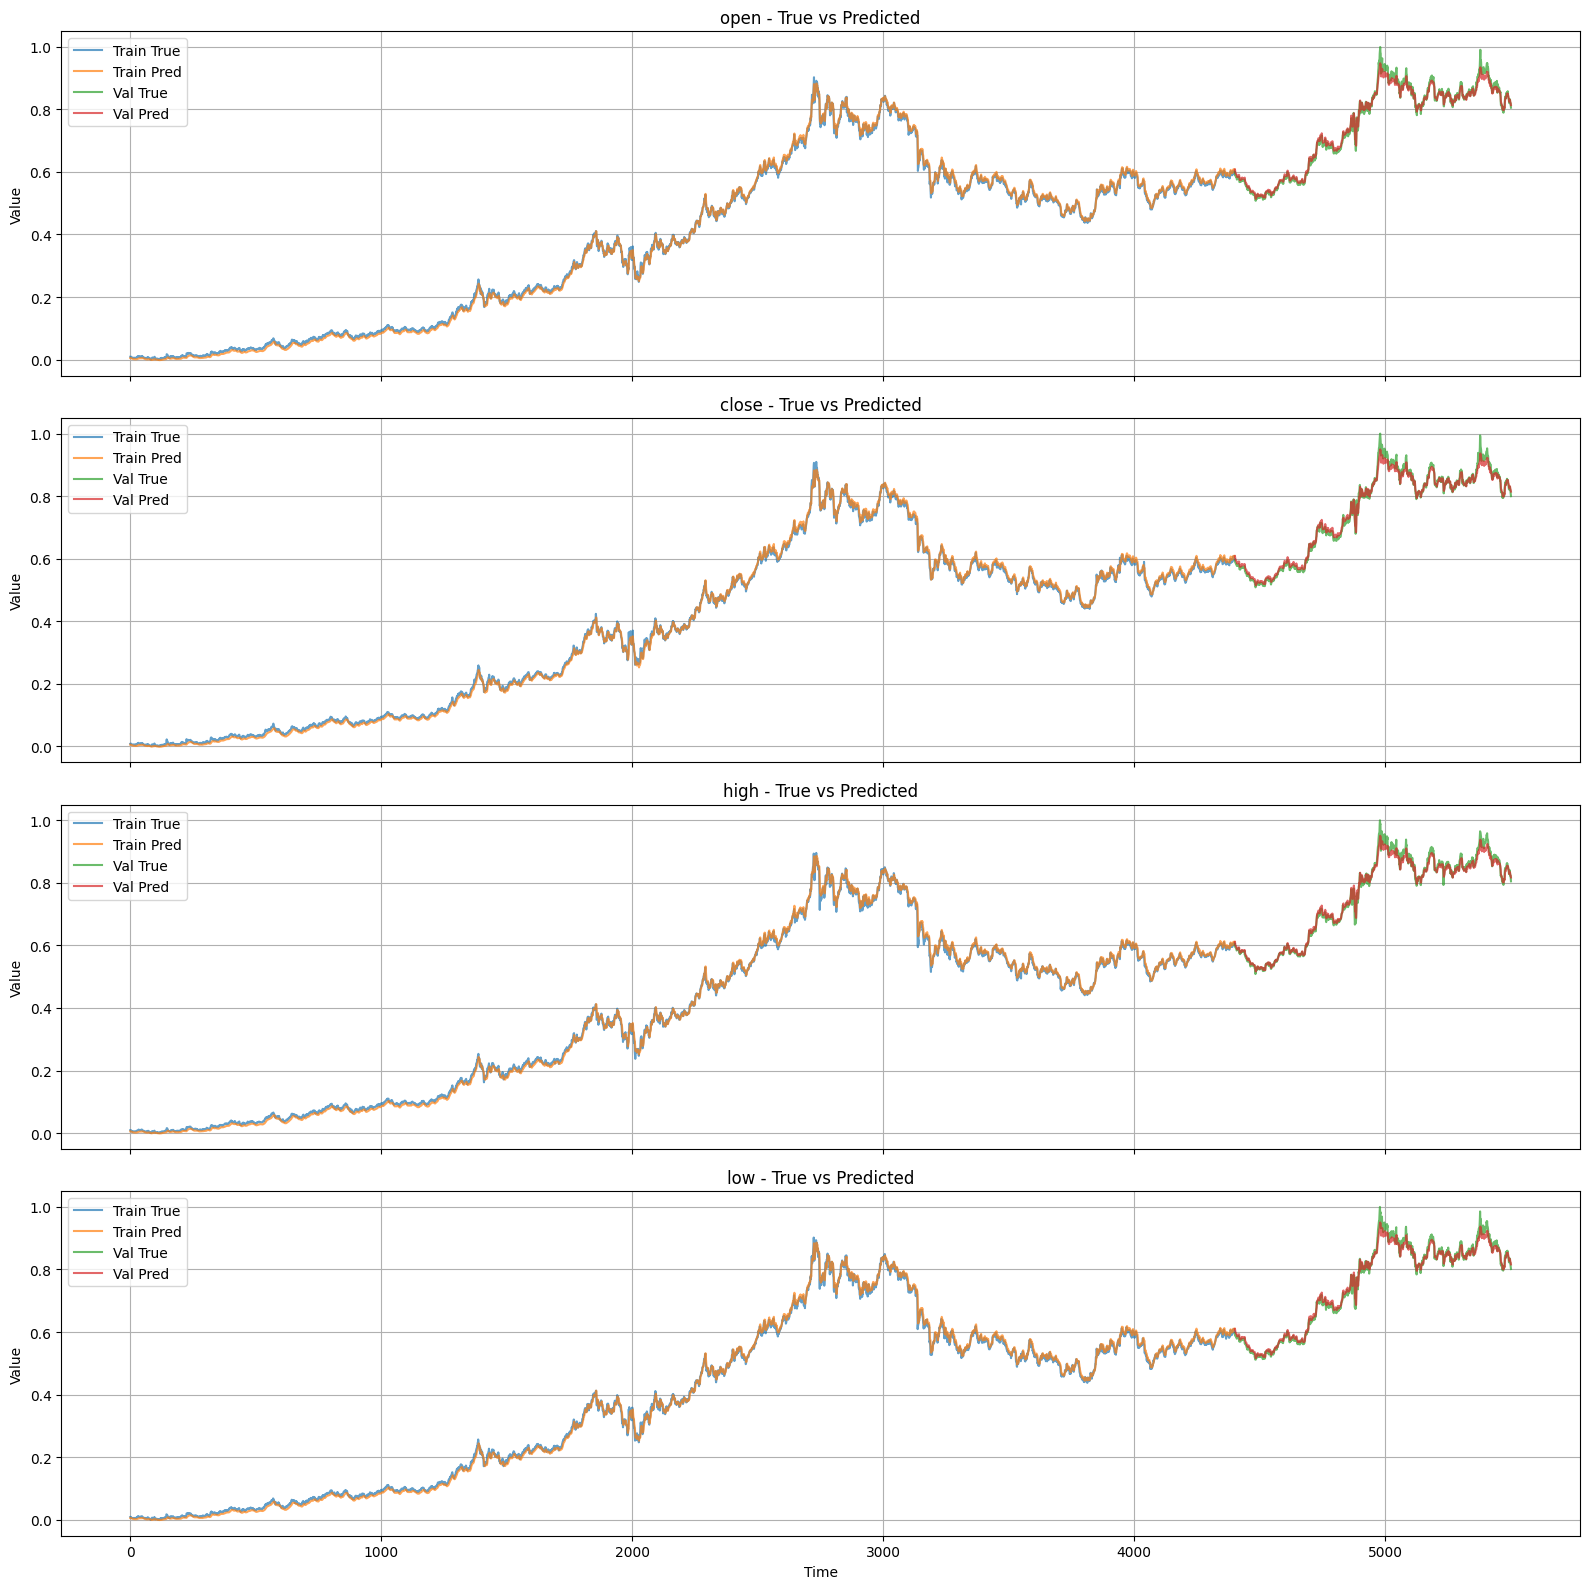

In [85]:
from sp2 import *
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


X, y = create_sequences(scaled_data, seq_length=200)
print(X.shape, y.shape)

# Split into training and validation datasets
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model initialization
input_size = len(data.columns)
gru_hidden_size = 100
lstm_hidden_size1 = 100
lstm_hidden_size2 = 50
dropout_rate = 0.2

model = HybridBiGRU_LSTM(input_size, gru_hidden_size, lstm_hidden_size1, lstm_hidden_size2, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
trained_model, loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device=device)

# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train.to(device)).cpu().numpy()
    y_pred_val = model(X_val.to(device)).cpu().numpy()

# Usage example:
# Assuming you want to pass feature names
plot_predictions(
    y_train.numpy(), 
    y_pred_train, 
    y_val.numpy(), 
    y_pred_val, 
    feature_names=['open', 'close', 'high', 'low']  # Customize as needed
)